# Imports

In [1]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil
import matplotlib.pyplot as plt
import time

from torchmetrics.detection import MeanAveragePrecision
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetaForObjectDetection
from transformers import DetaConfig, DetaImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

# Training

In [2]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_Wasser', processor=processor, image_name="coco_train.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_Wasser', processor=processor, image_name="coco_val.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


In [3]:
class Deta(pl.LightningModule):
	def __init__(self, lr, lr_backbone, weight_decay):
		super().__init__()
		# replace COCO classification head with custom head
		# we specify the "no_timm" variant here to not rely on the timm library
		# for the convolutional backbone
		self.model = DetaForObjectDetection.from_pretrained("jozhang97/deta-resnet-50",
															num_labels=len(id2label),
															auxiliary_loss=True,
															ignore_mismatched_sizes=True)
		# see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
		self.processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")
		self.save_hyperparameters()
		self.val_epoch_count = 0 # to not log at the first run
		self.lr = lr
		self.lr_backbone = lr_backbone
		self.weight_decay = weight_decay
		self.training_step_pred = []
		self.training_step_targ = []
		self.validation_step_pred = []
		self.validation_step_targ = []

	def forward(self, pixel_values, pixel_mask):
		outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
		return outputs

	def common_step(self, batch, batch_idx, t_v):
		pixel_values = batch["pixel_values"]
		pixel_mask = batch["pixel_mask"]
		labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

		outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

		loss = outputs.loss
		loss_dict = outputs.loss_dict

		#if t_v:
		#	self.data_prep_train(pixel_values, pixel_mask, labels)
		#else:
		#	self.data_prep_val(pixel_values, pixel_mask, labels)

		return loss, loss_dict

	def training_step(self, batch, batch_idx):
		loss, loss_dict = self.common_step(batch, batch_idx, True)
		# logs metrics for each training_step,
		# and the average across the epoch
		self.log("training_loss", loss)
		for k,v in loss_dict.items():
			self.log("train_" + k, v.item())
		return loss
	
	"""def on_train_epoch_end(self) -> None:
		print("onTrainEpoch")
		t1 = time.time()
		self.cmetric = MeanAveragePrecision(iou_type="bbox")
		self.cmetric.update(self.training_step_pred, self.training_step_targ)
		result = self.cmetric.compute()
		counter = 0
		for k, v in result.items():
			counter += 1
			if counter < 15:
				wandb.log({"train_epoch_" + k: v.item()})
				print({"train_" + k: v.item()})
		self.training_step_pred = []
		self.training_step_targ = []
		t2 = time.time()
		print(round(t2 - t1, 4))"""

	def validation_step(self, batch, batch_idx):
		loss, loss_dict = self.common_step(batch, batch_idx, False)
		self.log("validation_loss", loss)
		for k,v in loss_dict.items():
			self.log("validation_" + k, v.item())
		return loss
	
	"""def on_validation_epoch_end(self) -> None:
		if self.val_epoch_count == 1:
			print("onValEpoch")
			t1 = time.time()
			self.cmetric = MeanAveragePrecision(iou_type="bbox")
			self.cmetric.update(self.training_step_pred, self.training_step_targ)
			result = self.cmetric.compute()
			counter = 0
			for k, v in result.items():
				counter += 1
				if counter < 15:
					wandb.log({"validation_epoch_" + k: v.item()})
					print({"validation_epoch_" + k: v.item()})
			self.validation_step_pred = []
			self.validation_step_targ = []
			t2 = time.time()
			print(round(t2 - t1, 4))
		else:
			self.val_epoch_count = 1"""

	def configure_optimizers(self):
		param_dicts = [
				{"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
				{
					"params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
					"lr": self.lr_backbone,
				},
		]
		optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
									weight_decay=self.weight_decay)

		return optimizer

	def train_dataloader(self):
		return train_dataloader

	def val_dataloader(self):
		return val_dataloader
	
	"""def data_prep_train(self, pixel_values, pixel_mask, labels):

		with torch.no_grad():
			outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

		orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
		results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
		for n in results:
			self.training_step_pred.append(n)
		for i in labels:
			self.training_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})

	def data_prep_val(self, pixel_values, pixel_mask, labels):

		with torch.no_grad():
			outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

		orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
		results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
		for n in results:
			self.validation_step_pred.append(n)
		for i in labels:
			self.validation_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})"""

In [4]:
# Training

# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETA",
            "dataset": "All_Data_Wasser",
            "train_set_size": len(train_dataset)}
    )

model = Deta(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

# outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
# print(outputs.logits.shape)

max_steps_var = 1900

wandb_logger = WandbLogger("DETA", "../models/", project=project, log_model=True, checkpoint_name=f"DETA_Wasser_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1900` reached.


# Load Checkpoint
from Weights & Biases (Artifacts)

In [5]:
run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DETA_Wasser_1900_Steps:v0', type='model')
artifact_dir = artifact.download()

model = Deta.load_from_checkpoint(artifact_dir + "/model.ckpt")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

wandb: Downloading large artifact DETA_Wasser_1900_Steps:v0, 551.94MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5
Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.cla

Deta(
  (model): DetaForObjectDetection(
    (model): DetaModel(
      (backbone): DetaBackboneWithPositionalEncodings(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetaFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetaFrozenBatchNorm2d()
                    )
                    (layer):

# Evaluation

#### Funtion Declaration

In [6]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

#### Run Evaluation

In [14]:
# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0.00)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/215 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.236
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.0127, 0.0120, 0.0115, 0.0113, 0.0111, 0.0110, 0.0110, 0.0108, 0.0108,
        0.0108, 0.0107, 0.0105, 0.0103, 0.0102, 0.0100, 0.0100],
       device='cuda:0'), 'labels': tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'), 'boxes': tensor([[530.4294, 480.0408, 579.6815, 545.0208],
        [526.2128, 454.0908, 575.9083, 533.5748],
        [528.5562, 449.5104, 585.8313, 557.0304],
        [760.3972, 457.2352, 790.4681, 496.8692],
        [530.6390, 410.5569, 586.5932, 533.2822],
        [514.6274, 390.3722, 574.8781, 564.6700],
        [528.4915, 404.0034, 576.8232, 499.1769],
        [529.3438, 475.5907, 588.2520, 574.4952],
        [758.6785, 459.5377, 836.9381, 519.7105],
        [531.4774, 390.3431, 585.0262, 508.4877],
        [763.4968, 455.4759, 796.6097, 491.0951],
        [529.5490, 392.7714, 578.2017, 472.1892],
        [519.1081, 337.1833, 589.2984, 541.5254],
        [518.9192, 373.0399, 591.8221, 581.6392],
        [524.2955, 452.04

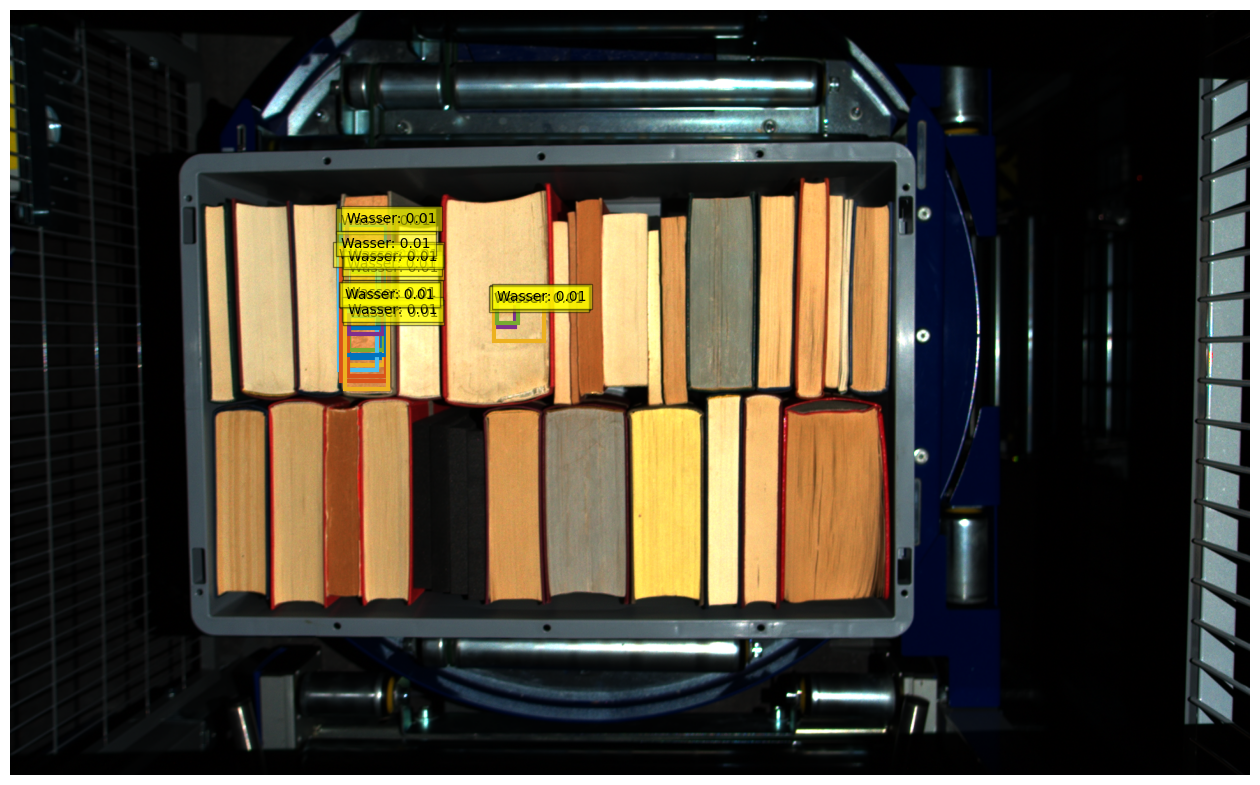

{'scores': tensor([0.0100, 0.0100], device='cuda:0'), 'labels': tensor([9, 9], device='cuda:0'), 'boxes': tensor([[1057.7744,  398.2438, 1089.6720,  467.6636],
        [1058.9725,  387.6116, 1090.9540,  452.3878]], device='cuda:0')}
{'Wasser': 2}
{}


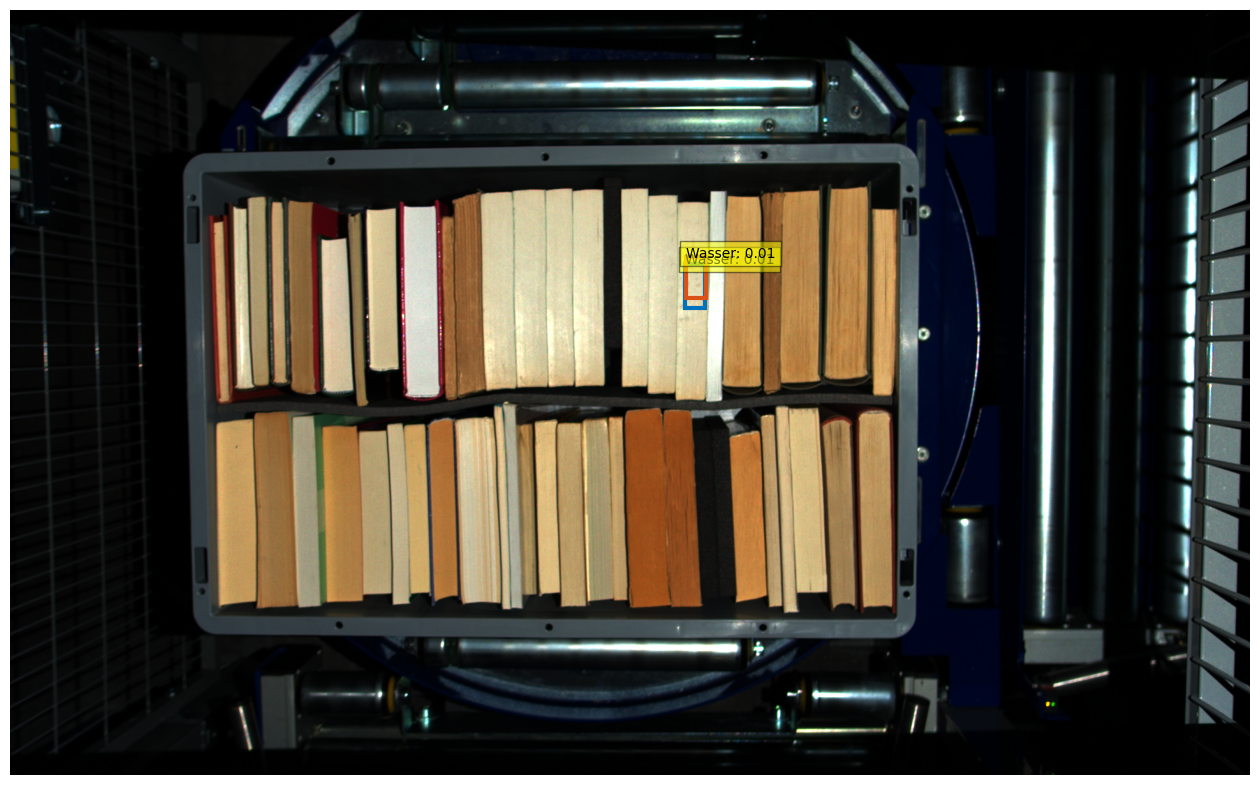

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{'Wasser': 1}


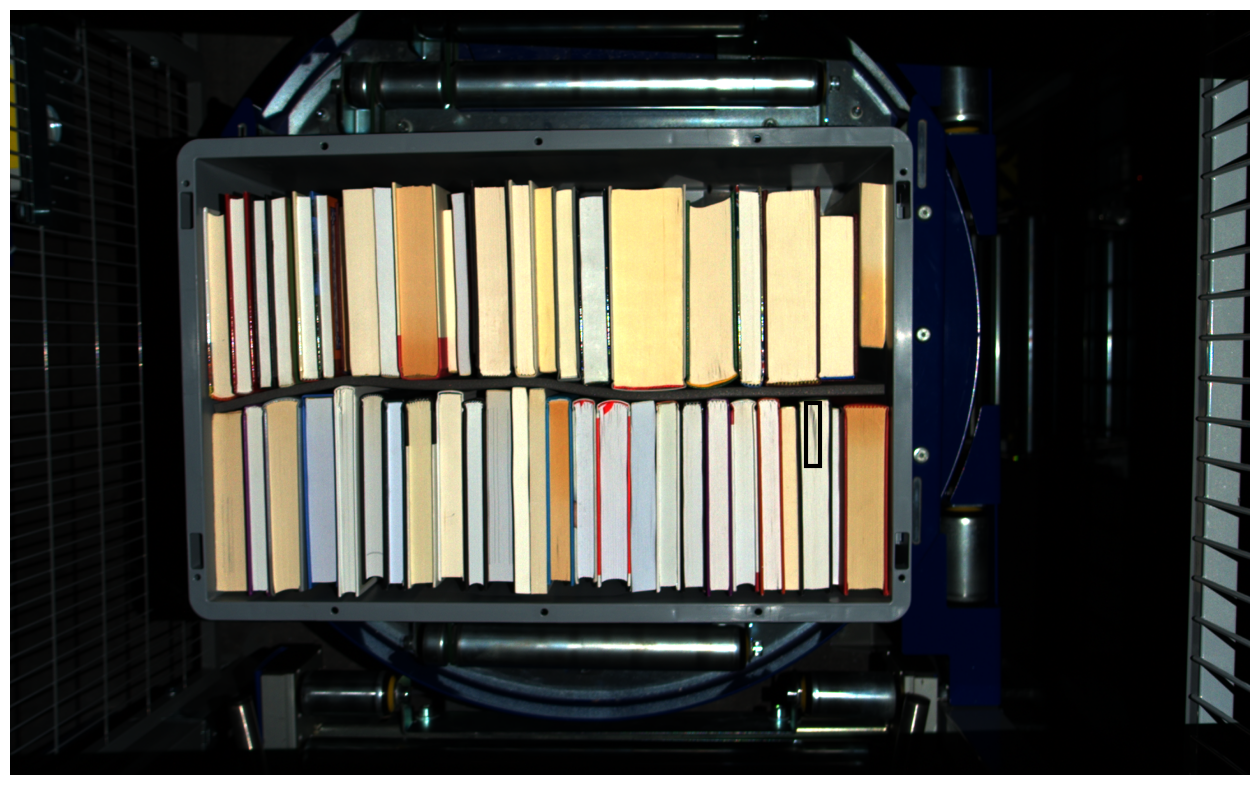

{'scores': tensor([0.0106, 0.0104, 0.0103, 0.0103, 0.0101, 0.0101], device='cuda:0'), 'labels': tensor([9, 9, 9, 9, 9, 9], device='cuda:0'), 'boxes': tensor([[395.4369, 371.9470, 429.1866, 415.1110],
        [404.5435, 369.5224, 430.6102, 419.1055],
        [775.5792, 647.6914, 802.6818, 689.9902],
        [775.8030, 646.1984, 808.3246, 683.6425],
        [405.6330, 377.4592, 430.9804, 428.0041],
        [772.6475, 639.3071, 810.9768, 684.9626]], device='cuda:0')}
{'Wasser': 6}
{'Wasser': 1}


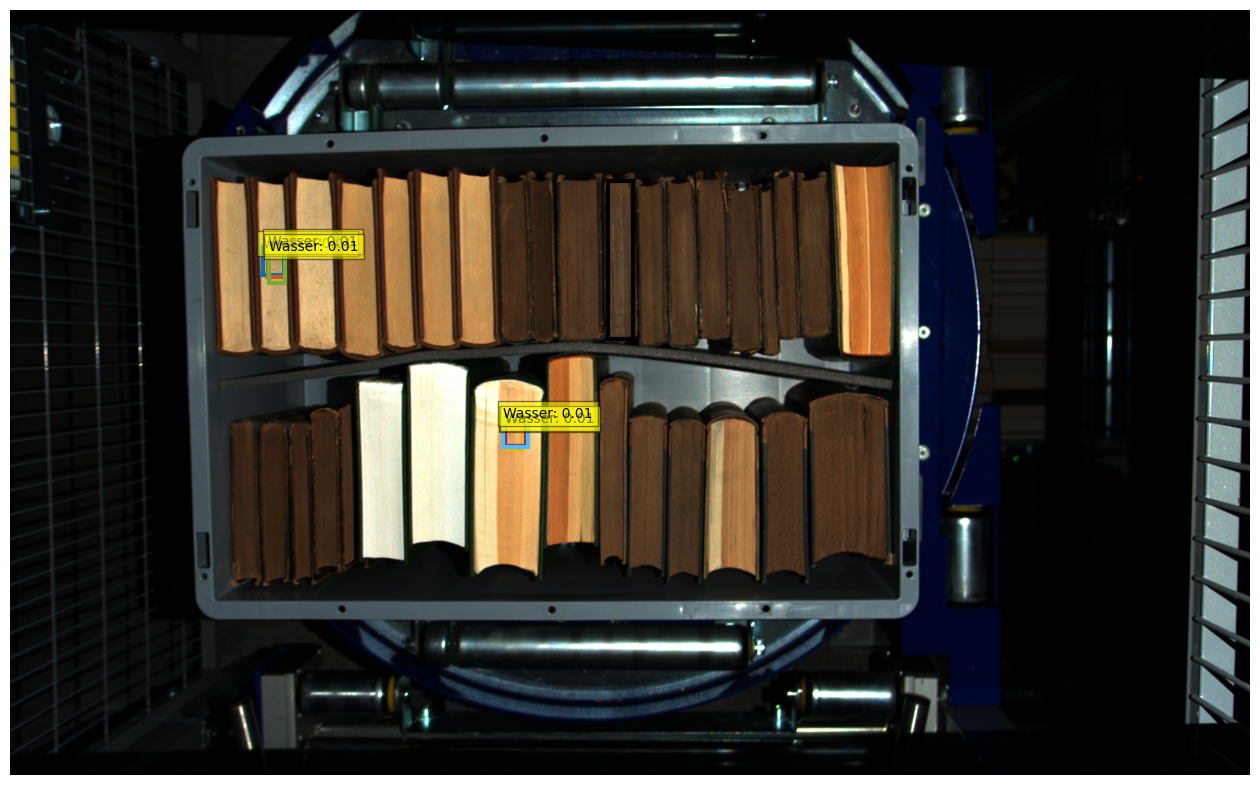

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{}


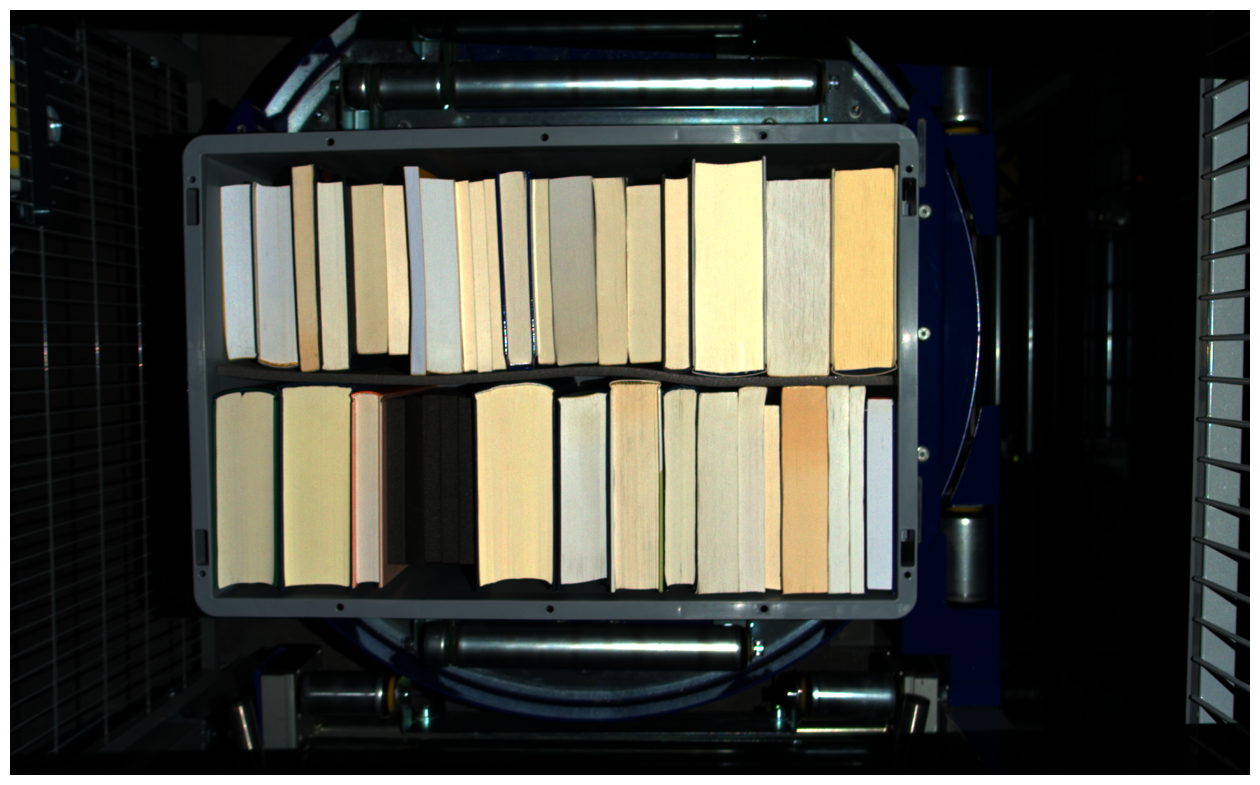

{'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
{}
{}


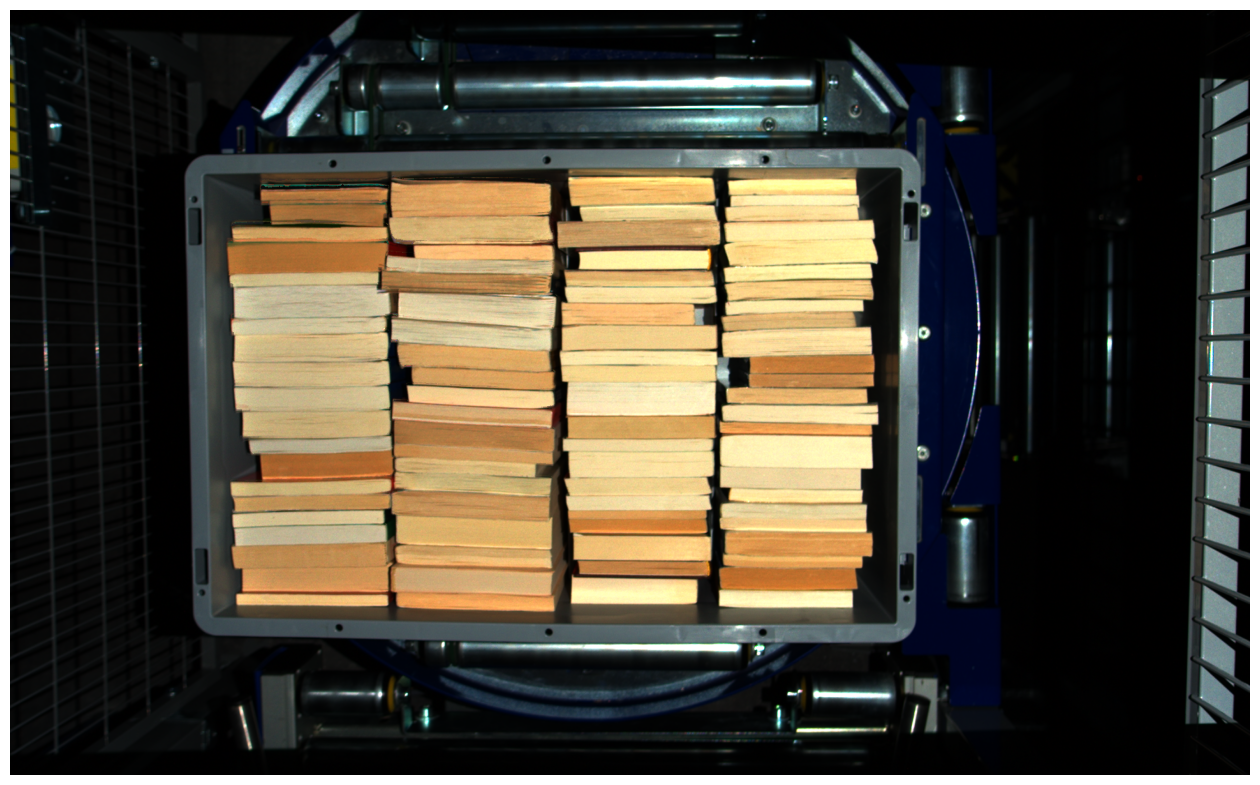

In [16]:
# TODO for a specific label use one specific color
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='black', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_Wasser', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.01)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)